<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_test_case_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# Imports for stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Please see MFD: comments and "to do" comments

# Generate switching data set

In [3]:
p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(1000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

#vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:

uni_data = df['T (degC)']
uni_date = df['Date Time']
uni_data.index = uni_date
uni_data.head()
#uni_data = uni_data.values
#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_data_mean)/uni_train_std
#print(uni_data)
#df = pd.DataFrame(vols, columns=['vol'])

#plt.plot(uni_date,uni_data)






Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [0]:
#df = pd.DataFrame(vols, columns=['vol'])

# prepare data for RNNs

In [5]:
use_features = ['T (degC)'] 
target = 'T (degC)'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

uni_train_mean = uni_data[:split].mean()
uni_train_std = uni_data[:split].std()
uni_data = (uni_data - uni_train_mean)/uni_train_std
print(uni_data)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

Date Time
01.01.2009 00:10:00   -2.014957
01.01.2009 00:20:00   -2.061161
01.01.2009 00:30:00   -2.073009
01.01.2009 00:40:00   -2.049314
01.01.2009 00:50:00   -2.044575
                         ...   
31.12.2016 23:20:00   -1.544616
31.12.2016 23:30:00   -1.461684
31.12.2016 23:40:00   -1.439174
31.12.2016 23:50:00   -1.565941
01.01.2017 00:00:00   -1.635840
Name: T (degC), Length: 420551, dtype: float64
        T (degC)
0          -8.02
1          -8.41
2          -8.51
3          -8.31
4          -8.27
...          ...
336435     18.15
336436     18.05
336437     17.93
336438     17.73
336439     17.57

[336440 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [8]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(336430, 10, 1) (336430, 1, 1) (84101, 10, 1) (84101, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]


In [10]:
print(train_batch_size)

336430


# Define Alpha RNN models

In [11]:
tf.get_collection('alpha_t')

[]

In [0]:
class alphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. It uses a hidden layer for smoothing
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Walpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Walpha')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ualpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ualpha')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.balpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='balpha')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha_t = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='alpha_t')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        self.W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
        self.b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
        self.output = tf.matmul(self.h_t, self.W_output) + self.b_output 

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Update alpha_t
        self.alpha_t = tf.sigmoid(tf.matmul(x_t, self.Walpha) + tf.matmul(h_tm1, self.Ualpha) + self.balpha)
        tf.add_to_collection('alpha_t', self.alpha_t)
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - self.alpha_t, h_tm1) + tf.multiply(self.alpha_t, h_proposal)
        return h_t

In [0]:
class simpleAlphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. 
       It uses a scalar smoothing
    
    
    Arguments
    ---------
    
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
        
    Todo
    --------
    1) how to constrain alpha to be in [0,1]?
    2) when hidden size >1, how to couple with scalar alpha?
    3) Should alpha be a vector of size hidden_size (is this better)?
    4) Get value of fitted alpha (see Diagnostics (visualize fitted values)) below
    4) Adapt the training to use early stopping (instead of fixed number of epoches)
    5) Compare with GRU, LSTM, simpleRNN
        
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='alpha')
        
        #tf.placeholder(dtype=tf.float64, shape=(None, 1), name='alpha')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

        self.W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
        self.b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
        self.output = tf.matmul(self.h_t, self.W_output) + self.b_output 

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - tf.tanh(self.alpha), h_tm1) + tf.multiply(tf.tanh(self.alpha), h_proposal)
        
        return h_t 


In [0]:
def train(session, alpharnn, train_x, val_x, train_y, val_y, max_epochs=2000, batch_size=100):
    
  # Create a placeholder for the expected output

  expected_output_batch_train = tf.placeholder(dtype=tf.float64, shape=(batch_size, train_y.shape[1],1), name='expected_output_batch_train')
  expected_output_train = tf.placeholder(dtype=tf.float64, shape=(train_x.shape[0], train_y.shape[1],1), name='expected_output_train')
  #expected_output_test = tf.placeholder(dtype=tf.float64, shape(test_x.shape[0], time_size,1), name='expected_output_test')
  expected_output_val = tf.placeholder(dtype=tf.float64, shape=(val_x.shape[0], train_y.shape[1],1), name='expected_output_val')

  #expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size), name='expected_output')

  # Just use quadratic loss
  train_batch_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_batch_train, 2)) / float(batch_size)
  train_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_train, 2)) / float(train_x.shape[0])
  validation_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_val, 2)) / float(val_x.shape[0])

  #accuracy = tf.reduce_mean(tf.cast(validation_loss, tf.float64))

  # Use the Adam optimizer for training
  train_step = tf.train.AdamOptimizer().minimize(train_batch_loss)
    
  # Initialize the losses
  train_losses = []
  validation_losses = []
      
  # Initialize all the variables
  init_variables = tf.global_variables_initializer()
      
  #myNumpyData = np.ones([10,20])
  session.run(init_variables) # , {gru.Y: np.ones([20,20])})
 
  # Perform all the iterations
  patience_cnt = 0
  for epoch in range(max_epochs): # Compute the losses
        patience = 50
        min_delta = 0.000001
        

        total_batch = int(train_x.shape[0] / batch_size)
    
        for i in range(total_batch):
          batch_x = train_x[i*batch_size:(i+1)*batch_size]
          batch_y = train_y[i*batch_size:(i+1)*batch_size]
          session.run([train_step], feed_dict={alpharnn.input_layer: batch_x, expected_output_batch_train: batch_y})        
        train_loss_ = session.run(train_loss, feed_dict={alpharnn.input_layer: train_x, expected_output_train: train_y})
        validation_loss_ = session.run(validation_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y})

        # Log the losses
        train_losses += [train_loss_]
        validation_losses += [validation_loss_]
          #mse = mean_squared_error(train_losses,validation_losses) <= this is wrong! 
          # I know...it's original values and the predicted values
        #keras uses: model.compile(loss='mean_squared_error', optimizer='sgd') 
        # and: keras.losses.mean_squared_error(y_true, y_pred)
        #y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
        #MSE = np.square(np.subtract(y_test_reg,y_predicted)).mean()

        if epoch % 50 == 0: 
            print('Epoch ', epoch, '/', max_epochs, ': ',
                      "\tTraining Loss: {:.5f}".format(train_loss_),
                      "\tValidation Loss: {:.5f}".format(validation_loss_),
                      #"\tloss:", MSE                      

                 )
        if epoch > 0 and (validation_losses[epoch-1] - validation_losses[epoch]) > min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
            #print(patience_cnt)
        if patience_cnt > patience:
            print("Early stopping")
            break
  saver = tf.train.Saver()
  saved_path = saver.save(session, './saved_variable')          
  #print('\nMSE: ',mse)
  plt.plot(train_losses, '-b', label='Train loss')
  plt.plot(validation_losses, '-r', label='Validation loss')
  plt.legend(loc=0)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()
  return alpharnn, validation_losses[-1] 

## Training

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 10 #<= MFD: vary this between 1,2,5,10,20


In [0]:
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#regularized_loss = total_loss + regularization_penalty

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch  0 / 2000 :  	Training Loss: 713.12185 	Validation Loss: 691.94445
Epoch  50 / 2000 :  	Training Loss: 646.26973 	Validation Loss: 627.92668
Epoch  100 / 2000 :  	Training Loss: 588.16763 	Validation Loss: 572.26085
Epoch  150 / 2000 :  	Training Loss: 536.17026 	Validation Loss: 522.48447
Epoch  200 / 2000 :  	Training Loss: 489.29284 	Validation Loss: 477.62779
Epoch  250 / 2000 :  	Training Loss: 446.79441 	Validation Loss: 436.98150
Epoch  300 / 2000 :  	Training Loss: 408.11921 	Validation Loss: 399.99856
Epoch  350 / 2000 :  	Training Loss: 372.83912 	Validation Loss: 366.27917
Epoch  400 / 2000 :  	Training Loss: 340.60693 	Validation Loss: 335.49909
Epoch  450 / 2000 :  	Training Loss: 311.13901 	Validation Loss: 307.38533
Epoch  500 / 2000 :  	Training Loss: 284.19746 	Validation Loss: 281.70767
Epoch  550 / 2000 :  	Training Loss: 259.57599 	Validation Loss: 258.26542
Epoch  60

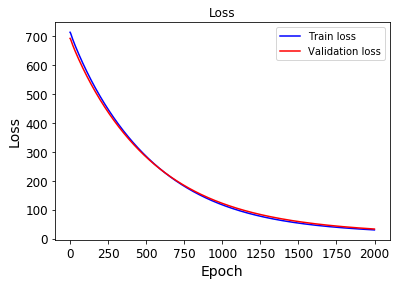

Epoch  0 / 2000 :  	Training Loss: 701.26951 	Validation Loss: 739.80784
Epoch  50 / 2000 :  	Training Loss: 582.04364 	Validation Loss: 611.96423
Epoch  100 / 2000 :  	Training Loss: 486.31758 	Validation Loss: 509.99991
Epoch  150 / 2000 :  	Training Loss: 407.40745 	Validation Loss: 426.32891
Epoch  200 / 2000 :  	Training Loss: 341.61972 	Validation Loss: 356.70383
Epoch  250 / 2000 :  	Training Loss: 286.60007 	Validation Loss: 298.55466
Epoch  300 / 2000 :  	Training Loss: 240.63870 	Validation Loss: 250.02163
Epoch  350 / 2000 :  	Training Loss: 202.35207 	Validation Loss: 209.60061
Epoch  400 / 2000 :  	Training Loss: 170.49216 	Validation Loss: 175.97111
Epoch  450 / 2000 :  	Training Loss: 144.03308 	Validation Loss: 148.09985
Epoch  500 / 2000 :  	Training Loss: 122.10940 	Validation Loss: 125.10753
Epoch  550 / 2000 :  	Training Loss: 103.97499 	Validation Loss: 106.21717
Epoch  600 / 2000 :  	Training Loss: 88.98756 	Validation Loss: 90.74178
Epoch  650 / 2000 :  	Training

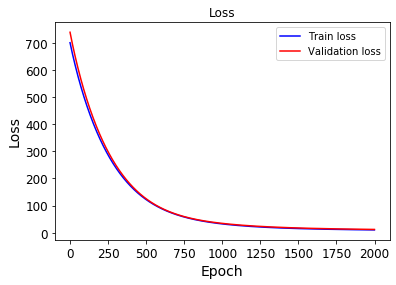

Epoch  0 / 2000 :  	Training Loss: 713.35712 	Validation Loss: 775.82073
Epoch  50 / 2000 :  	Training Loss: 532.90233 	Validation Loss: 583.99474
Epoch  100 / 2000 :  	Training Loss: 403.70953 	Validation Loss: 444.94689
Epoch  150 / 2000 :  	Training Loss: 306.69818 	Validation Loss: 339.41181
Epoch  200 / 2000 :  	Training Loss: 233.36115 	Validation Loss: 258.70642
Epoch  250 / 2000 :  	Training Loss: 178.11961 	Validation Loss: 196.95145
Epoch  300 / 2000 :  	Training Loss: 136.70236 	Validation Loss: 149.77436
Epoch  350 / 2000 :  	Training Loss: 105.88864 	Validation Loss: 114.02914
Epoch  400 / 2000 :  	Training Loss: 83.08812 	Validation Loss: 87.23028
Epoch  450 / 2000 :  	Training Loss: 66.23879 	Validation Loss: 67.34962
Epoch  500 / 2000 :  	Training Loss: 53.75058 	Validation Loss: 52.72888
Epoch  550 / 2000 :  	Training Loss: 44.42784 	Validation Loss: 42.03194
Epoch  600 / 2000 :  	Training Loss: 37.38787 	Validation Loss: 34.20316
Epoch  650 / 2000 :  	Training Loss: 3

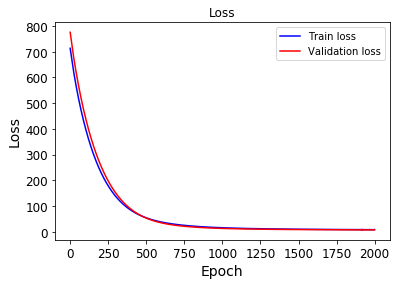

Epoch  0 / 2000 :  	Training Loss: 727.75081 	Validation Loss: 821.16369
Epoch  50 / 2000 :  	Training Loss: 497.45003 	Validation Loss: 549.88992
Epoch  100 / 2000 :  	Training Loss: 345.32887 	Validation Loss: 372.13866
Epoch  150 / 2000 :  	Training Loss: 240.22083 	Validation Loss: 250.86358
Epoch  200 / 2000 :  	Training Loss: 167.66465 	Validation Loss: 168.75035
Epoch  250 / 2000 :  	Training Loss: 117.97583 	Validation Loss: 113.96388
Epoch  300 / 2000 :  	Training Loss: 84.43178 	Validation Loss: 78.09118
Epoch  350 / 2000 :  	Training Loss: 62.00464 	Validation Loss: 54.89995
Epoch  400 / 2000 :  	Training Loss: 47.01977 	Validation Loss: 39.97870
Epoch  450 / 2000 :  	Training Loss: 36.90303 	Validation Loss: 30.33538
Epoch  500 / 2000 :  	Training Loss: 29.94820 	Validation Loss: 24.03517
Epoch  550 / 2000 :  	Training Loss: 25.04127 	Validation Loss: 19.82257
Epoch  600 / 2000 :  	Training Loss: 21.45982 	Validation Loss: 16.88765
Epoch  650 / 2000 :  	Training Loss: 18.74

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
batch_size  = 30000
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = alphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size =int(batch_size/n_splits))
  val_loss+=val_loss_
 val_losses.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
se = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_train_t)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses2=[]
batch_size  = int(30000/n_splits)
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn, x_train, x_test, y_train, y_test, max_epochs, batch_size)
  val_loss+=val_loss_
 val_losses2.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses2))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn = SimpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:
#session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 


#model,_=train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

       

In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

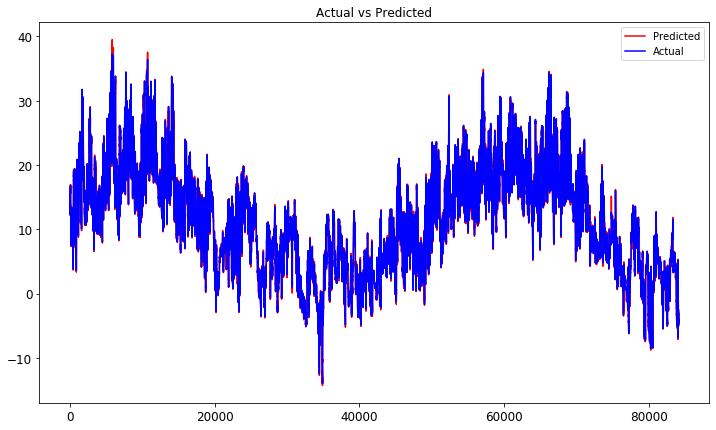

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()


## Cross-Validation

In [0]:
# Create a new instance of the alpha_RNN model
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)

alpharnn_cv = alphaRNN(input_dimensions, hidden_size)

In [0]:
# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) #prediction

In [0]:
def cross_validate(session, split_size):

  results = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    train(alpharnn, train_x, val_x, train_y, val_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results


In [0]:
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  #result = cross_validate(session, 5)
  #print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))

NameError: ignored

In [0]:
session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
alpharnn_t = alphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn_t.h_t) 

train(alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


Epoch  0 / 200 :  	Training Loss: 21.43568 	Validation Loss: 37.10702
Epoch  50 / 200 :  	Training Loss: 3.98413 	Validation Loss: 4.01063
Epoch  100 / 200 :  	Training Loss: 4.01077 	Validation Loss: 4.08058
Epoch  150 / 200 :  	Training Loss: 3.95643 	Validation Loss: 3.97600


KeyboardInterrupt: ignored

In [0]:
#train_loss = 0
#expected_output_test = 0
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  result = cross_validate(session, 5)
  print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn_t.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]


In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_train_reg})
y_predicted_ar_train_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
print(train_losses[0][1])

## Diagnostics (visualize fitted values)

In [0]:

# MFD: It would be good to visualize the amount of smoothing, but I get an error
#alpha=session.run(alpharnn.alpha, feed_dict={alpharnn.input_layer: x_test_reg})

In [0]:
#plt.plot(alpha_t[:,n_steps-1,1], 'red')
#pplt.plot(y_test_reg.flatten(),'blue')

# Comparsion with Keras GRU, RNN, LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)
 
 

MFD: batch size must match that used for alpha_RNN when comparing LSTM



In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model


In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']


Hyper parameter tuning for RNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
hidden_size = nodes
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=30000, callbacks=[es])

In [0]:
# predict out of sample
hidden_size = nodes # optimal number of nodes
rnn_model = RNN_model2(hidden_size,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=30000, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

In [0]:
#tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for  GRU...")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_gru = nodes_gru
gru_model = Sequential()
gru_model.add(GRU(hidden_size_gru, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=30000, callbacks=[es])

In [0]:
gru_model = GRU_model2(hidden_size_gru,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=30000, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

In [0]:
#tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_lstm = nodes_lstm
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size_lstm, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=30000, callbacks=[es])

In [0]:
# predict ouf of sample
lstm_model = LSTM_model2(hidden_size,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=30000, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/500
56075/56075 [==============================] - 2s 27us/step - loss: 3.0704
Epoch 2/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.1056
Epoch 3/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0871
Epoch 4/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0736
Epoch 5/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0649
Epoch 6/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0593
Epoch 7/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0532
Epoch 8/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0503
Epoch 9/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0468
Epoch 10/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0461
Epoch 11/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 12/500
56075/56075 [===============

In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#       print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/500
56075/56075 [==============================] - 2s 27us/step - loss: 3.0704
Epoch 2/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.1056
Epoch 3/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0871
Epoch 4/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0736
Epoch 5/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0649
Epoch 6/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0593
Epoch 7/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0532
Epoch 8/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0503
Epoch 9/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0468
Epoch 10/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0461
Epoch 11/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 12/500
56075/56075 [===============

### LSTM


### RNN

### GRU

### Prediction

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 40us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 2s 26us/step


In [0]:
# compare with the trained plain GRU

In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 39us/step


### Model Performance

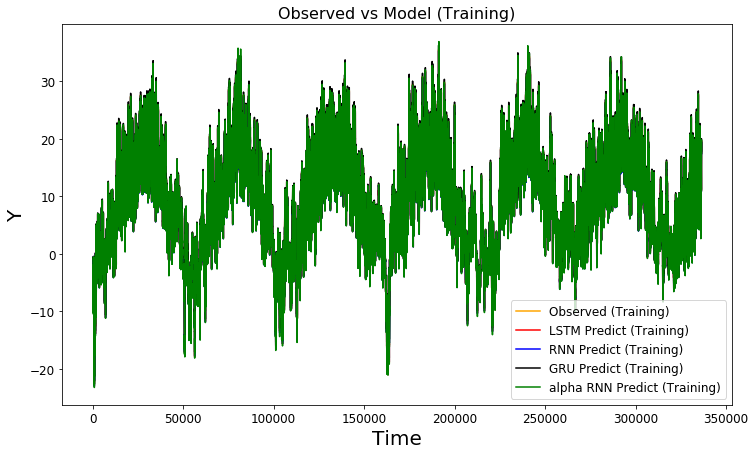

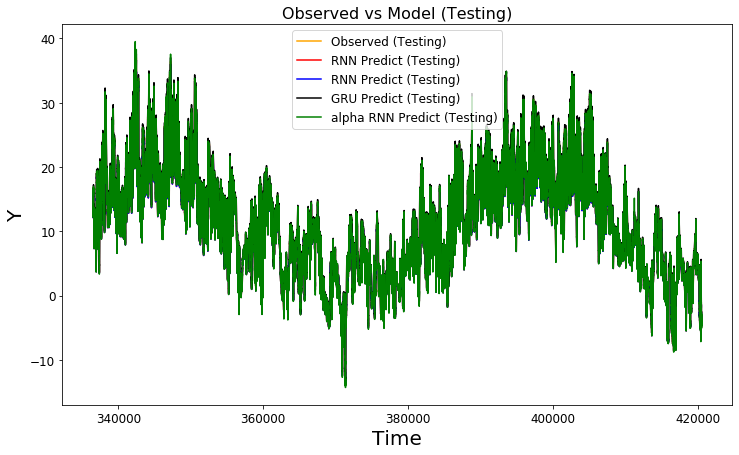

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train_t, color="yellow", label="alpha_t RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar_t, color="yellow",label="alpha_t RNN Predict (Testing)"
test_line_pred = plt.plot(y_predicted_ar_t, color="yellow", label="alpha_t RNN Predict (Testing)")

# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
# calculate mean squared error of the plain LSTM
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], lstm_pred_test[:, 0])
print(MSE_test)

NameError: ignored

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)